# Variatonal AutoEncoder for generative learning and latent space exploration


In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from numpy import savetxt
from scipy.sparse.linalg import expm, expm_multiply
from scipy import sparse

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Layer, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [2]:
"Now we import and preprocess the registers"
"We import the registers"
n_Delta=100 
Delta_vec=np.linspace(1,5,n_Delta)

Delta_class=list(range(n_Delta))


diccionario_clases=dict(zip(Delta_vec,Delta_class))




out_name = "C:/Users/Manuel/Desktop/universidad/beca_gefes_2021/proyecto/archivos_clicks/n_Delta_100_n_clicks_100/clicks_deltas_Omega_3.csv"

Deltas_and_clicks=loadtxt(out_name,delimiter=",")


y_full=Deltas_and_clicks[:,0] 
y_full_class=np.vectorize(diccionario_clases.get)(y_full)
X_full=Deltas_and_clicks[:,1:] 

"We are only interested in the time difference between photons"
X_full[:,1:]=X_full[:,1:]-X_full[:,:-1]



ratio=0.8
limit=int(ratio*len(y_full))
y_train,y_valid=y_full_class[:limit],y_full_class[limit:]

"We reescale the photon times so that the inputs are between 0 and 1 as it is in that range where we have"
"the most expresivity of the activation functions"
maxX=np.amax(X_full)
X_train,X_valid=X_full[:limit,:]/maxX,X_full[limit:,:]/maxX


In [3]:
"For creating a VAE we need to create a Sampling Layer"
"Construimos la capa de sampling"

class Sampling(Layer):
    """Custom Keras layer to sample the codings (the vector encoding a digit)"""
    
    def call(self, inputs):
        # Takes mean and log_var (gamma) as parameters
        mean, log_var = inputs
        # Sample a random codings vector with same shape as gamma from a Gaussian distribution 
        # exp(gamma/2) = sigma
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [4]:
"We create the Variational AutoEncoder"

latent_dim = 2 

# Define encoder model
original_inputs = Input(shape=X_full.shape[1], name="encoder_input")

z = Dense(150, activation="selu")(original_inputs)
z = Dense(100, activation="selu")(z)
z = Dense(20, activation="selu")(z)

codings_mean = Dense(latent_dim, name="codings_mean")(z)
codings_log_var = Dense(latent_dim, name="codings_log_var")(z)
codings = Sampling()((codings_mean, codings_log_var))

vae_encoder = Model(inputs=original_inputs, outputs=codings, name="encoder")

vae_encoder.summary() 


# Define decoder model
latent_inputs = Input(shape=(latent_dim))

x = Dense(20, activation="selu")(latent_inputs)
x = Dense(100, activation="selu")(x)

x = Dense(150, activation="selu")(x)
outputs = Dense(X_full.shape[1], activation="sigmoid")(x)

vae_decoder = Model(inputs=latent_inputs, outputs=outputs, name="decoder")

vae_decoder.summary()

# Define VAE model
codings = vae_encoder(original_inputs)
outputs = vae_decoder(codings)
vae = Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
vae.add_loss(K.mean(latent_loss) / 784.)

def rounded_accuracy(y_true, y_pred):
    """Define a custom accuracy metric by round predictions"""
    
    return binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Train the VAE
vae.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[rounded_accuracy])

history = vae.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_valid, X_valid),
    verbose=1,
)



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 150)          15150       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          15100       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           2020        dense_1[0][0]                    
____________________________________________________________________________________________

1250/1250 [==============================] - 6s 5ms/step - loss: 0.1843 - rounded_accuracy: 0.9998 - val_loss: 0.1842 - val_rounded_accuracy: 0.9998
Epoch 34/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1843 - rounded_accuracy: 0.9998 - val_loss: 0.1842 - val_rounded_accuracy: 0.9998
Epoch 35/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1843 - rounded_accuracy: 0.9998 - val_loss: 0.1842 - val_rounded_accuracy: 0.9998
Epoch 36/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.1843 - rounded_accuracy: 0.9998 - val_loss: 0.1842 - val_rounded_accuracy: 0.9998
Epoch 37/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1843 - rounded_accuracy: 0.9998 - val_loss: 0.1842 - val_rounded_accuracy: 0.9998
Epoch 38/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1842 - rounded_accuracy: 0.9998 - val_loss: 0.1842 - val_rounded_accuracy: 0.9998
Epoch 39/50
1250/1250 [=======================

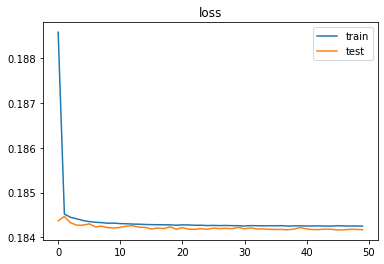

In [5]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("loss")
plt.legend(["train","test"])
plt.show()

In [6]:
def logS_t(Omega,Delta,t):
    #Te calcula la matriz que debes exponenciar
    #para tener S(t), introduces la Omega y el tiempo como argumento
    aux=np.matrix(np.zeros((4,4)),dtype=complex)
    aux[0,1]=1j*t*Omega
    aux[0,2]=-1j*t*Omega
    aux[1,0]=1j*t*Omega
    aux[1,1]=t*(-1/2+1j*Delta)
    aux[1,3]=-1j*t*Omega
    aux[2,0]=-1j*t*Omega
    aux[2,2]=t*(-1/2-1j*Delta)
    aux[2,3]=1j*t*Omega
    aux[3,1]=-1j*t*Omega
    aux[3,2]=1j*t*Omega
    aux[3,3]=-1*t
    
    return aux


def trace_liouv(density_matrix):
    #aquí defino una función auxiliar que me 
    #saca la traza de la matriz densidad cuando está dada en forma vector
    return density_matrix[0]+density_matrix[3]


def delta_prob_distribution(clicks_processed, Delta_vec, Omega):
    J=np.matrix(np.zeros((4,4)))
    J[0,3]=1
    J=sparse.csr_matrix(J)
    n_Delta=len(Delta_vec)
    
    
    # Definimos las matrices densidad en el instante inicial
    ro_0=np.asarray([1,0,0,0],dtype=complex)
    
    prob_matrix=np.zeros(n_Delta)
    
    for j in range(n_Delta):
        Delta=Delta_vec[j]
        ro=ro_0
        for i in range(len(clicks_processed)):
            t=clicks_processed[i]
            ro=expm(logS_t(Omega,Delta,t)).dot(ro)
            ro=J.dot(ro)
            #print(trace_liouv(ro_list[j]).real)
        prob_matrix[j]=trace_liouv(ro).real
        #print("j= "+str(j))
    prob_matrix_normalised=prob_matrix/(np.sum(prob_matrix[:]))
    
    return prob_matrix_normalised

In [7]:
"Let's study its latent space"
X_full_divided = X_full / maxX
delta_masked = (y_full_class ==  + 0)
for i in range(4):
    delta_masked = delta_masked + (y_full_class == (i+1)*20 - 1)

X_full_masked = X_full_divided[delta_masked]

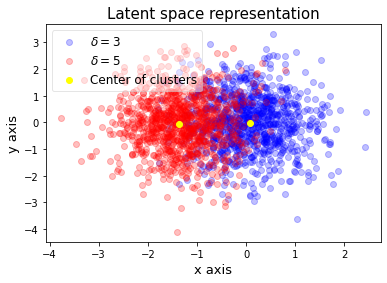

In [8]:
"Let's plot delta = 3 and 5 and see how the center of their clusters separate"

delta_1_clicks = X_full_divided[y_full_class == 50] 
delta_5_clicks = X_full_divided[y_full_class == 99] 

delta_1_enc = vae_encoder.predict(delta_1_clicks)
delta_5_enc = vae_encoder.predict(delta_5_clicks)

plt.scatter(delta_1_enc[:,0], delta_1_enc[:,1], color= "blue", alpha = 0.25)
plt.scatter(delta_5_enc[:,0], delta_5_enc[:,1], color= "red", alpha = 0.25)


delta_1_x_mean = np.mean(delta_1_enc[:,0])
delta_1_y_mean = np.mean(delta_1_enc[:,1])
plt.scatter(delta_1_x_mean, delta_1_y_mean, color= "yellow")

delta_5_x_mean = np.mean(delta_5_enc[:,0])
delta_5_y_mean = np.mean(delta_5_enc[:,1])
plt.scatter(delta_5_x_mean, delta_5_y_mean, color= "yellow")
plt.title("Latent space representation", fontsize = 15)
plt.xlabel("x axis", fontsize = 13)
plt.ylabel("y axis", fontsize = 13)
plt.legend(["$\delta = 3$","$\delta = 5$", "Center of clusters"], 
           fontsize = 12, framealpha = 0.5, loc = 2)

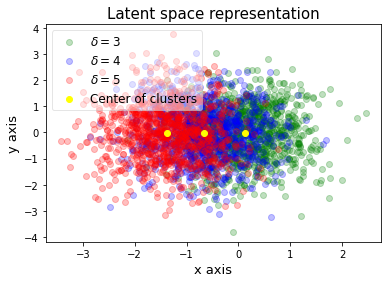

In [9]:
"Now delta =3, 4 y 5"
delta_3_clicks = X_full_divided[y_full_class == 50] 
   
delta_4_clicks = X_full_divided[y_full_class == 75] 
delta_5_clicks = X_full_divided[y_full_class == 99] 


delta_3_enc = vae_encoder.predict(delta_3_clicks)

delta_4_enc = vae_encoder.predict(delta_4_clicks)
delta_5_enc = vae_encoder.predict(delta_5_clicks)

plt.scatter(delta_3_enc[:,0], delta_3_enc[:,1], color= "green", alpha = 0.25)

plt.scatter(delta_4_enc[:,0], delta_4_enc[:,1], color= "blue", alpha = 0.25)
plt.scatter(delta_5_enc[:,0], delta_5_enc[:,1], color= "red", alpha = 0.25)


delta_3_x_mean = np.mean(delta_3_enc[:,0])
delta_3_y_mean = np.mean(delta_3_enc[:,1])
plt.scatter(delta_3_x_mean, delta_3_y_mean, color= "yellow")




delta_4_x_mean = np.mean(delta_4_enc[:,0])
delta_4_y_mean = np.mean(delta_4_enc[:,1])
plt.scatter(delta_4_x_mean, delta_4_y_mean, color= "yellow")

delta_5_x_mean = np.mean(delta_5_enc[:,0])
delta_5_y_mean = np.mean(delta_5_enc[:,1])
plt.scatter(delta_5_x_mean, delta_5_y_mean, color= "yellow")

plt.title("Latent space representation", fontsize = 15)
plt.xlabel("x axis", fontsize = 13)
plt.ylabel("y axis", fontsize = 13)
plt.legend(["$\delta = 3$","$\delta = 4$","$\delta = 5$", "Center of clusters"], 
           fontsize = 12, framealpha = 0.5, loc = 2)


In [10]:
"Now that we have the VAE we can generate new registers with physical sense"
codings = tf.random.normal(shape=[12, latent_dim])
generated_clicks = vae_decoder(codings).numpy()*maxX

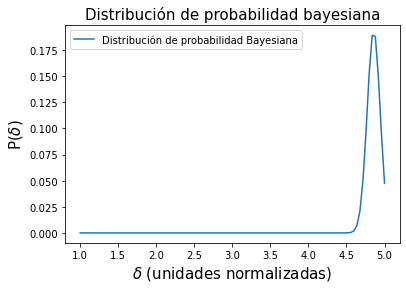

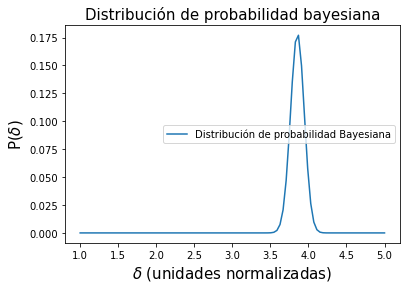

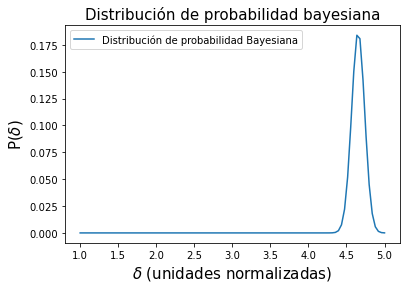

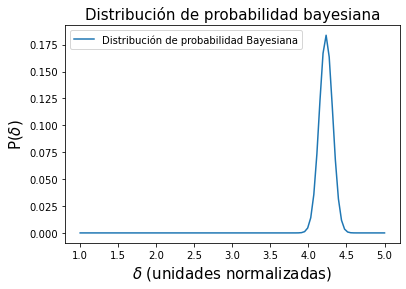

In [11]:
for loc in range(4):
    prob_matrix_normalised= delta_prob_distribution(
        clicks_processed = generated_clicks[loc,:],
        Delta_vec = Delta_vec,
        Omega=3)
    
    plt.figure()
    plt.plot(Delta_vec,prob_matrix_normalised)
    plt.legend(["Distribución de probabilidad Bayesiana","Valor simulado"])
    
    plt.xlabel("$\delta$ (unidades normalizadas)",fontsize=15)
    plt.ylabel("P($\delta$)",fontsize=15)
    plt.title("Distribución de probabilidad bayesiana",fontsize=15)
    plt.show()
    plt.close()